# Assignment 5: Block Matching and Harris Corner Detection
## Ex. 5.1 Dense Optical Flow by Block Matching
* implement the block matching method as shown in the lecture
* take two frames from the datasets "lane_detection" or "copter_flight" with variable distances in time (1, 2, x) and compute the vector flow field
* display a subset of flow vectors on the gray-value version of the first image, by drawing a respective line. adjust the grid density such that not too many vectors overlap (**RESULT**)

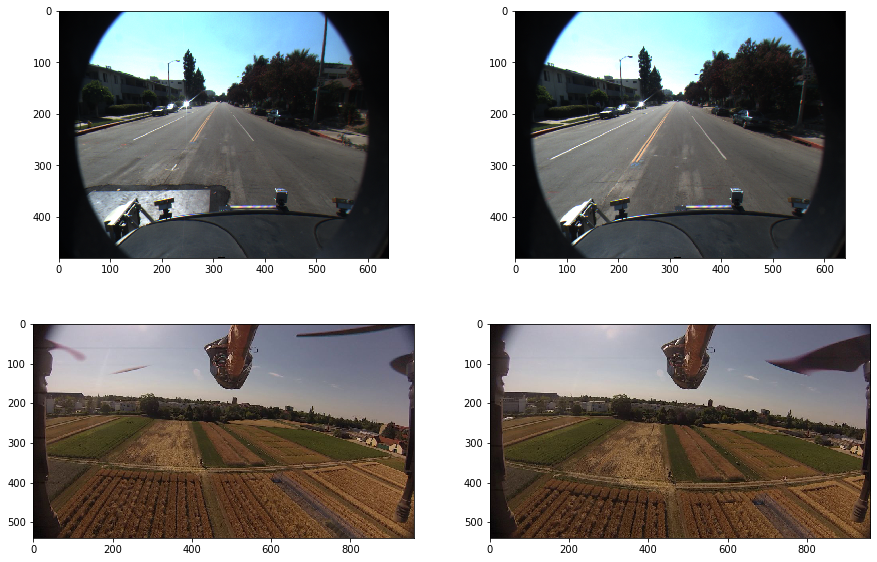

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import numpy as np

# Chose other images if you like
lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00001.png')

# Footage from our Neurocopter project:
# http://berlinbiorobotics.blog/projects/neurocopter/
copter1 = io.imread('images/copter_flight/frame050.jpg')
copter2 = io.imread('images/copter_flight/frame052.jpg') 

fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax21 = plt.subplot(2, 2, 3)
ax22 = plt.subplot(2, 2, 4)

ax11.imshow(lane1)
ax12.imshow(lane2)

ax21.imshow(copter1)
ax22.imshow(copter2)

In [2]:
import numpy as np
from tqdm import tqdm

In [3]:
from skimage.color import rgb2gray

def block_match(img, img_next, block_size=81, max_transition=100, transition_step=10, metrik='corr', in_gray=False):
    assert img.shape == img_next.shape
    assert metrik in ['corr', 'mse']
    
    # if wished, convert both images to grayscale
    if in_gray:
        img = rgb2gray(img)
        img_next = rgb2gray(img_next)
    
    # image height/width
    h, w = img.shape[:2]
    
    # block transition deltas
    Dx = np.arange(-max_transition, max_transition + 1, transition_step)
    Dy = Dx.copy()

    #block size / half block size
    hbs = block_size // 2
    
    in_img = lambda x, y: y >= hbs and x >= hbs and y < h - hbs and x < w - hbs
    
    flow_vectors = []
    # iterate through image blocks
    for y in tqdm(range(hbs, h - hbs, hbs)):
        for x in range(hbs, w - hbs, hbs):
            
            # store normalized vector of image values in block
            block = img[y - hbs : y + hbs + 1, x - hbs : x + hbs + 1].ravel()
            if metrik == 'corr':
                # normalize vector of block
                block = block / np.linalg.norm(block)
            
            scores = np.zeros((2*max_transition + 1, 2*max_transition + 1))
            # iterate through deltas in each direction
            for dx in Dx:
                for dy in Dy:
                    if not (in_img(x + dx, y + dy)):
                        continue
                        
                    # store normalized vector of image values in delta-block
                    d_block = img_next[y - hbs + dy : y + hbs + 1 + dy, x - hbs + dx : x + hbs + 1 + dx].ravel()
                    
                    # correlation
                    if metrik == 'corr':
                        # normalize vector of block
                        d_block = d_block / np.linalg.norm(d_block)
                        scores[max_transition + dy, max_transition + dx] = np.dot(block, d_block)
                    # negative MSE
                    elif metrik == 'mse':
                        scores[max_transition + dy, max_transition + dx] = - np.sum((block - d_block)**2)
                    
            
            argmax = np.unravel_index(np.argmax(scores, axis=None), scores.shape)
            flow_vector = argmax[0] - max_transition, argmax[1] - max_transition
            flow_vectors.append(( (y,x), flow_vector, scores[argmax] ))

    return flow_vectors

100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


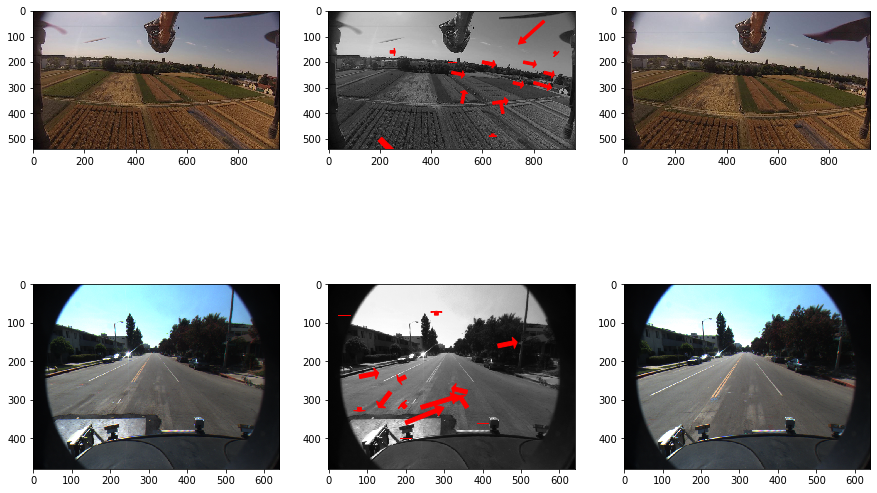

In [4]:
from matplotlib.patches import Arrow

def show_flow(img, flow_vectors, ax):
    grayscale_img = rgb2gray(img)
    ax.imshow(grayscale_img, cmap='gray')
    
    # pick random 15 flow vectors
    np.random.seed(42)
    random_choice = np.random.choice(np.arange(len(flow_vectors)), 15)
    chosen_flow_vectors = np.array(flow_vectors)[random_choice]
    
    # draw an arrow at center of block and use deltas for direction and size
    for (y, x), (dy, dx), score in chosen_flow_vectors:
        arrow_patch = Arrow(x, y, dx, dy, width=50, color='red')
        ax.add_patch(arrow_patch)
        
    
    arrow_patch = Arrow(200, 500, 100, 100, width=100, color='red')
    ax.add_patch(arrow_patch)
    
    
    
    

def show_block_matching(img11, img12, img21, img22):
    fig = plt.figure(figsize=(15, 10))
    ax11 = plt.subplot(2, 3, 1)
    ax12 = plt.subplot(2, 3, 2)
    ax13 = plt.subplot(2, 3, 3)
    ax21 = plt.subplot(2, 3, 4)
    ax22 = plt.subplot(2, 3, 5)
    ax23 = plt.subplot(2, 3, 6)
    
    ax11.imshow(img11)
    ax13.imshow(img12)
    
    ax21.imshow(img21)
    ax23.imshow(img22)
    
    flow_img1 = block_match(img11, img12)
    flow_img2 = block_match(img21, img22)
    show_flow(img11, flow_img1, ax12)
    show_flow(img21, flow_img2, ax22)
    
show_block_matching(copter1, copter2, lane1, lane2)

# A note on performance

It seems like it's working, but there are 2 very intuitive problems:
* matching non-unique blocks such as the ones in the sky is not reliable, as all deltas result in a high score
* matching objects at the end of the frame which are lost in the next frame is impossible. This also produces invalid flow vectors

## Ex. 5.2 Harris Corner Detection
* implement the Harris Corner Detector as discussed in the lecture
* compute corners in the first image and track them with Lucas-Kanade (use e.g. the function "calcOpticalFlowPyrLK" in OpenCV)
* mark the positions of your Harris corners and draw the flow vectors found by Lucas-Kanade on the gray-value versions of the first image (**RESULT**)

In [5]:
from scipy import ndimage

def get_ix_iy(img):
    sx = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
    sy = sx.T
    
    Ix = ndimage.convolve(img, sx)
    Iy = ndimage.convolve(img, sy)
    
    return Ix, Iy
    

def detect_corners(img, threshold=-5e8, k=0.06):
    # convert image to grayscale, use integer representation
    img = np.array(rgb2gray(img) * 255, dtype=int)
    # pad image
    img = np.pad(img, 1, 'constant')
    
    res = np.zeros(img.shape, dtype=int)
    h, w = img.shape[:2]
    
    # get integral image
    Ix, Iy = get_ix_iy(img)
    Ix2, Iy2 = Ix * Ix, Iy * Iy
    Ixy = Ix * Iy
    
    # iterate through image
    scores = []
    for y in tqdm(range(h)):
        for x in range(w):
            # calculate structure tensor
            A = np.array([
                [Ix2[y,x], Ixy[y,x]],
                [Ixy[y,x], Iy2[y,x]]
            ])
            # calculate harris corner score
            score = np.linalg.det(A) - k * (np.trace(A)**2)
            # save for easier thershold analysis
            scores.append(score)
            
            # if score below certain threshold, we found a corner
            if score <= threshold:
                res[y,x] = -score
                
    # save intermediate non-suppressed result for visualization
    res_non_suppressed = res.copy()
    res_non_suppressed[res_non_suppressed > 0] = 1
              
    # pad result for easier non-max-suppression
    res = np.pad(res, 1, 'constant')
    # perform non-max-suppression
    for y in range(1, h-1):
        for x in range(1, w-1):
            block = res[y-1:y+2, x-1:x+2]
            
            if np.amax(block) != res[y,x]:
                res[y,x] = 0
                
    # unpad result
    res = res[1:-1, 1:-1]
    # binarize
    res[res>0] = 1

    return res_non_suppressed, res, scores

In [6]:
import pandas as pd

def show_harris_corners(img, threshold):
    fig = plt.figure(figsize=(15, 10))
    ax11 = plt.subplot(1, 3, 1)
    ax12 = plt.subplot(1, 3, 2)
    ax13 = plt.subplot(1, 3, 3)
    
    # show original image
    ax11.imshow(img)
    
    # compute harris corners
    corners_non_suppressed, corners, scores = detect_corners(img, threshold=threshold)
    
    # show corners without non-max-suppression
    ax12.imshow(corners_non_suppressed, cmap='gray')
    
    # show result after suppression
    ax13.imshow(corners, cmap='gray')
    
    # display threshold info
    print(f"Threshold: {threshold}")
    
    # display info about scores to adjust threshold
    print('Scores info:')
    return pd.DataFrame(scores).describe()

100%|██████████| 482/482 [00:08<00:00, 59.86it/s]


Threshold: -500000000.0
Scores info:


0
count  3.094440e+05
mean  -1.633800e+08
std    1.973831e+09
min   -5.053745e+10
25%   -2.018400e+04
50%   -4.034400e+02
75%   -6.000000e+00
max    0.000000e+00

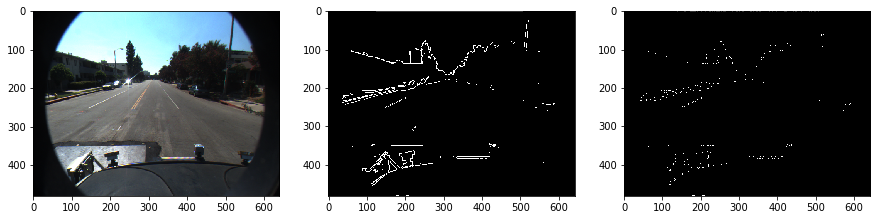

In [7]:
show_harris_corners(lane1, -5e8)

100%|██████████| 482/482 [00:08<00:00, 60.09it/s]


Threshold: -8000000.0
Scores info:


0
count  3.094440e+05
mean  -1.633800e+08
std    1.973831e+09
min   -5.053745e+10
25%   -2.018400e+04
50%   -4.034400e+02
75%   -6.000000e+00
max    0.000000e+00

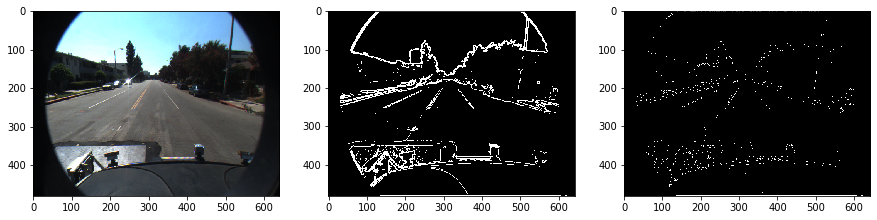

In [8]:
show_harris_corners(lane1, -8e6)

100%|██████████| 542/542 [00:13<00:00, 40.20it/s]


Threshold: -500000000.0
Scores info:


0
count  5.214040e+05
mean  -6.564076e+07
std    8.681114e+08
min   -3.837888e+10
25%   -8.718806e+05
50%   -1.685400e+04
75%   -6.144000e+01
max    0.000000e+00

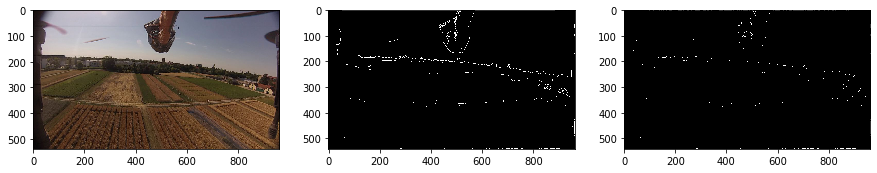

In [9]:
show_harris_corners(copter1, -5e8)

100%|██████████| 542/542 [00:13<00:00, 39.43it/s]


Threshold: -8000000.0
Scores info:


0
count  5.214040e+05
mean  -6.564076e+07
std    8.681114e+08
min   -3.837888e+10
25%   -8.718806e+05
50%   -1.685400e+04
75%   -6.144000e+01
max    0.000000e+00

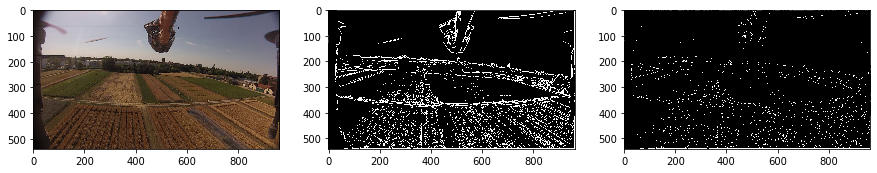

In [10]:
show_harris_corners(copter1, -8e6)

# Time for Lucas-Kanade

In [11]:
import cv2

def show_lk(img, img_next):
    # get points of interest
    _, corners, _ = detect_corners(lane1, threshold=-8e9)
    # extract corners from returned binary image
    corners = np.array([[x] for x in np.argwhere(corners>0)], dtype=np.float32)

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                      maxLevel = 2,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # convert image to grayscale, in format expected by cv2::calcOpticalFlowPyrLK
    img_gray, img_next_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img_next, cv2.COLOR_BGR2GRAY)


    # calculate optical flow
    new_corners, st, err = cv2.calcOpticalFlowPyrLK(img_gray, img_next_gray, corners , None, **lk_params)

    # select matched points from LK
    good_new = new_corners[st==1]
    good_old = corners[st==1]

    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img_gray, cmap='gray')

    # draw the tracks
    for i, (new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()

        arrow_patch = Arrow(c, d, a-c, b-d, width=10, color='red')
        ax.add_patch(arrow_patch)

    plt.show()

100%|██████████| 482/482 [00:08<00:00, 59.93it/s]


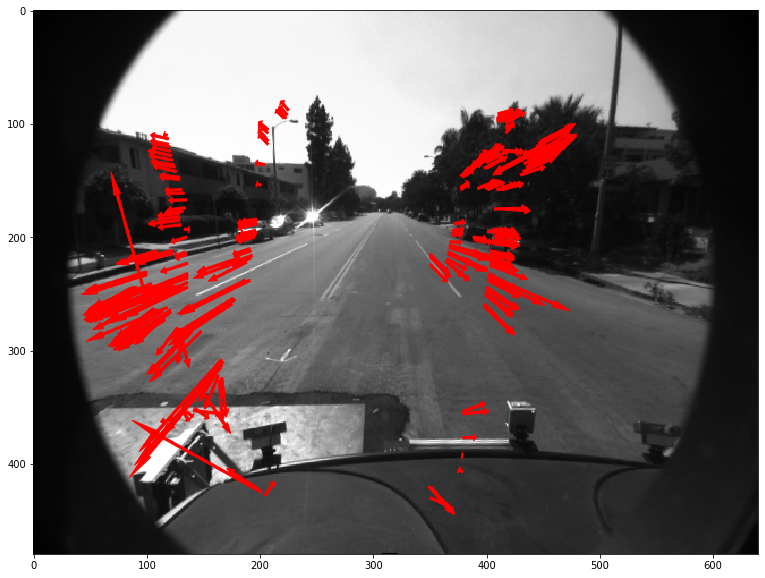

In [12]:
show_lk(lane1, lane2)

100%|██████████| 482/482 [00:08<00:00, 59.43it/s]


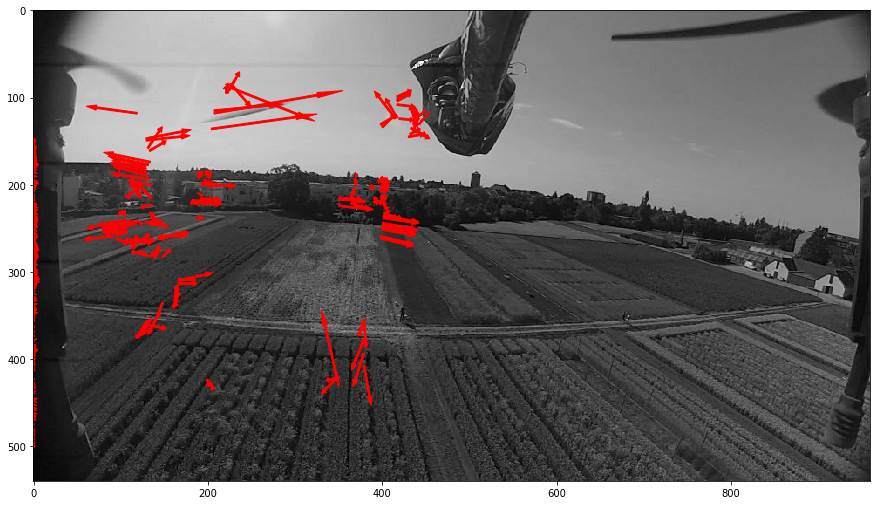

In [13]:
show_lk(copter1, copter2)